# Functions

In [82]:
# Import statements

import h5py
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


from scipy.signal import savgol_filter


In [83]:

# Import single sleap file for analysis 

# filename = '/Users/ellasay/Google Drive/My Drive/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'
def import_single_slp(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]

    print("===filename===")
    print(filename)
    print()

    print("===HDF5 datasets===")
    print(dset_names)
    print()

    print("===locations data shape===")
    print(locations.shape)
    print()

    print("===nodes===")
    for i, name in enumerate(node_names):
        print(f"{i}: {name}")
    print()

# Modified to apply to whole directory of h5 files

def import_h5_dir(directory):
    # Get a list of all .h5 files in the directory
    h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]

    # Initialize an empty list to store data for the DataFrame
    data = []

    for h5_file in h5_files:
        filename = os.path.join(directory, h5_file)
        
        # Open and process the .h5 file
        with h5py.File(filename, "r") as f:
            # dset_names = list(f.keys())
            locations = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]
            
            # Append the data to the list
            condition = extract_condition(h5_file)
            filename = extract_filename(h5_file)
            data.append({
                'file_name': h5_file,
                'name': filename,
                'location shape': locations.shape,
                'locations': locations,
                'condition': condition

            })
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def extract_condition(filename):
    start = filename.find("_") + 1
    end = filename.find("_0", start)
    if start > 1 and end > -1:
        return filename[start:end]
    return None

def extract_filename(filename):
    start = 0
    end = filename.find(".h5", start)
    return filename[start:end]
  


# Fill in missing values (NaN vavlues due to tracking errors)
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

NOSE_INDEX = 0
LEFTEAR_INDEX = 1
RIGHTEAR_INDEX = 2
TORSO_INDEX = 3
TAILBASE = 4

def store_nodes(row):
    nodes = {
        'nose':NOSE_INDEX,
        'leftear': LEFTEAR_INDEX,
        'rightear':RIGHTEAR_INDEX,
        'torso': TORSO_INDEX,
        # 'left_hindpaw': LEFT_HINDPAW,
        # 'right_hindpaw':RIGHT_HINDPAW,
        'tailbase':TAILBASE
    }
    location_dict = {}
    locations = row['locations']

    for node, index in nodes.items():

        x_coords = locations[:,index,0,0]
        y_coords = locations[:,index,1,0]
        location_dict[f'{node}_x'] = x_coords
        location_dict[f'{node}_y'] = y_coords
        # node_loc = locations[:,index,:,:].reshape(-1)
        # location_dict[node] = node_loc

    return pd.Series(location_dict)


# Import dir of .slp files

In [66]:
directory_path = '/Volumes/groups/giocomo/esay/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5'  # Replace with your directory path
df = import_single_slp(directory_path)
print(df)

===filename===
/Volumes/groups/giocomo/esay/behavior/1.SLEAP/h5/Archive/day1_ctrl_restricted_wheel.mp4.000_day1_ctrl_restricted_wheel.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(36292, 7, 2, 1)

===nodes===
0: Nose
1: Left_ear
2: Right_ear
3: Torso
4: Left_hindpaw
5: Right_hindpaw
6: Tailbase

None


In [84]:
# directory_path = '/Users/ellasay/Google Drive/My Drive/can_project/behavior/v2_model/all_h5'  # Replace with your directory path
directory_path = '/Users/ellasay/Documents/can_project/all_h5'
df = import_h5_dir(directory_path)
print(df)

                                file_name                                name  \
0   day4_unrestrictednovdiffsex_0914.1.h5  day4_unrestrictednovdiffsex_0914.1   
1          day3_unrestrictednov_0914.4.h5         day3_unrestrictednov_0914.4   
2   day4_unrestrictednovdiffsex_0921.2.h5  day4_unrestrictednovdiffsex_0921.2   
3          day4_unrestrictednov_0914.1.h5         day4_unrestrictednov_0914.1   
4          day4_unrestrictednov_0921.2.h5         day4_unrestrictednov_0921.2   
5          day3_unrestrictednov_0921.2.h5         day3_unrestrictednov_0921.2   
6   day4_unrestrictednovdiffsex_0914.4.h5  day4_unrestrictednovdiffsex_0914.4   
7          day3_unrestrictednov_0914.1.h5         day3_unrestrictednov_0914.1   
8          day4_unrestrictednov_0914.4.h5         day4_unrestrictednov_0914.4   
9          day2_unrestrictedfam_0914.1.h5         day2_unrestrictedfam_0914.1   
10         day2_unrestrictedfam_0921.2.h5         day2_unrestrictedfam_0921.2   
11         day2_unrestricted

In [ ]:
# organize into table based on condition

# conditions: fixed wheel vs not fixed wheel, novel vs familiar, restricted vs unrestricted


# Fill in NaN values

In [85]:
df['locations'] = df['locations'].apply(fill_missing) # fill_missing is NOT a vectorized function (cannot apply to whole column)

print(df)

                                file_name                                name  \
0   day4_unrestrictednovdiffsex_0914.1.h5  day4_unrestrictednovdiffsex_0914.1   
1          day3_unrestrictednov_0914.4.h5         day3_unrestrictednov_0914.4   
2   day4_unrestrictednovdiffsex_0921.2.h5  day4_unrestrictednovdiffsex_0921.2   
3          day4_unrestrictednov_0914.1.h5         day4_unrestrictednov_0914.1   
4          day4_unrestrictednov_0921.2.h5         day4_unrestrictednov_0921.2   
5          day3_unrestrictednov_0921.2.h5         day3_unrestrictednov_0921.2   
6   day4_unrestrictednovdiffsex_0914.4.h5  day4_unrestrictednovdiffsex_0914.4   
7          day3_unrestrictednov_0914.1.h5         day3_unrestrictednov_0914.1   
8          day4_unrestrictednov_0914.4.h5         day4_unrestrictednov_0914.4   
9          day2_unrestrictedfam_0914.1.h5         day2_unrestrictedfam_0914.1   
10         day2_unrestrictedfam_0921.2.h5         day2_unrestrictedfam_0921.2   
11         day2_unrestricted

# store node locations

In [86]:
df = df.join(df.apply(store_nodes,axis=1))
print(df)
print(df.shape)


                                file_name                                name  \
0   day4_unrestrictednovdiffsex_0914.1.h5  day4_unrestrictednovdiffsex_0914.1   
1          day3_unrestrictednov_0914.4.h5         day3_unrestrictednov_0914.4   
2   day4_unrestrictednovdiffsex_0921.2.h5  day4_unrestrictednovdiffsex_0921.2   
3          day4_unrestrictednov_0914.1.h5         day4_unrestrictednov_0914.1   
4          day4_unrestrictednov_0921.2.h5         day4_unrestrictednov_0921.2   
5          day3_unrestrictednov_0921.2.h5         day3_unrestrictednov_0921.2   
6   day4_unrestrictednovdiffsex_0914.4.h5  day4_unrestrictednovdiffsex_0914.4   
7          day3_unrestrictednov_0914.1.h5         day3_unrestrictednov_0914.1   
8          day4_unrestrictednov_0914.4.h5         day4_unrestrictednov_0914.4   
9          day2_unrestrictedfam_0914.1.h5         day2_unrestrictedfam_0914.1   
10         day2_unrestrictedfam_0921.2.h5         day2_unrestrictedfam_0921.2   
11         day2_unrestricted

In [87]:
# add head as a node (average between ears) because ears are the most consistent in video

df['head_x'] = (df['leftear_x'] + df['rightear_x']) / 2
df['head_y'] = (df['leftear_y'] + df['rightear_y']) / 2

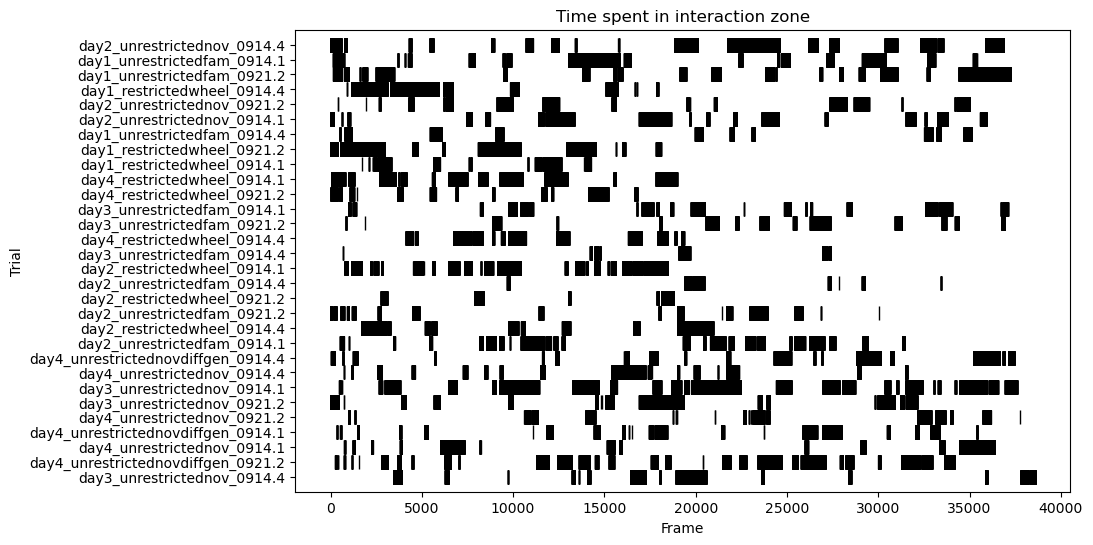

In [72]:
# quantify amount of time spent on the sides vs the middle

# Initialize an empty list to store frame indices for each trial
filtered_frames = []


for i, row in df.iterrows():
    # nose_x = np.array(row['nose_x']).astype(float)
    # nose_y = np.array(row['nose_y']).astype(float)

    head_x = np.array(row['head_x']).astype(float)
    head_y = np.array(row['head_y']).astype(float)
    
    # interaction zone x = [300,400] y=[200,300]
    # int_zone = (nose_x >= 300) & (nose_x <= 400) & (nose_y >= 200) & (nose_y <= 300)
    int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)

    frame_indices = np.where(int_zone)[0]  

    filtered_frames.append(frame_indices)

# plot raster
fig, ax = plt.subplots(figsize=(10, 6))

for i, frames in enumerate(filtered_frames):
    ax.plot(frames, np.ones_like(frames) * i, '|', color='black', markersize=10)  # Raster points for each trial

# Labeling the plot
ax.set_title('Time spent in interaction zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
ax.set_yticks(range(len(filtered_frames)))
ax.set_yticklabels(df['name'])

ax.set_ylim(-1, len(filtered_frames))

plt.show()





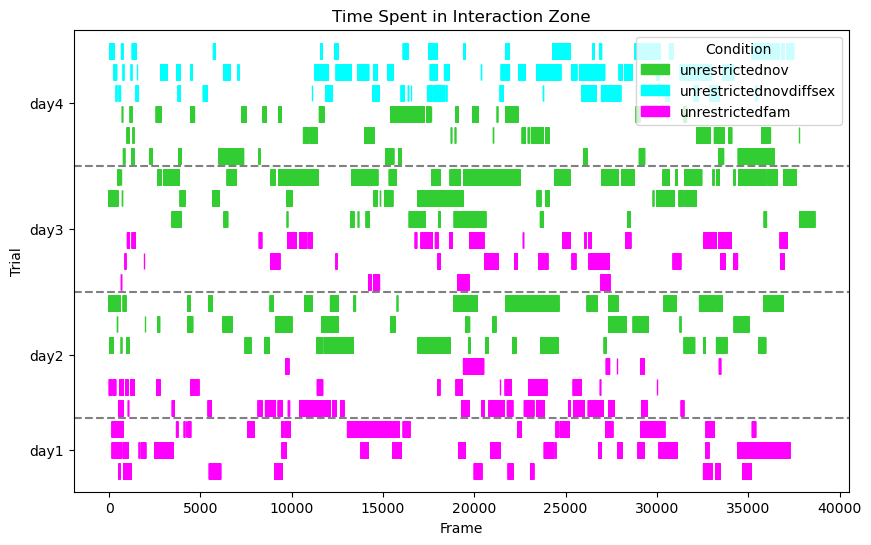

In [104]:
# plot raster with colors + days 
import matplotlib.patches as mpatches

condition_colors = {
    # "restrictedwheel": "grey",
    # "restrictwheel": "blue",
    "unrestrictednov": "limegreen",
    "unrestrictednovdiffsex": "cyan",
    "unrestrictedfam": "magenta"
    # "unrestricted_fam": "orange"
}

# Initialize an empty list to store frame indices for each trial and colors for each condition
filtered_frames = []
conditions = []

# Extract day number and add as a new column for sorting
df['day'] = df['name'].str.extract(r'day(\d)').astype(int)
# df = df.sort_values(by='day').reset_index(drop=True)
df = df.sort_values(by=['day', 'condition']).reset_index(drop=True)


for i, row in df.iterrows():
    head_x = np.array(row['head_x']).astype(float)
    head_y = np.array(row['head_y']).astype(float)
    
    # Define interaction zone
    int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)
    frame_indices = np.where(int_zone)[0]  

    filtered_frames.append(frame_indices)
    conditions.append(row['condition'])  # Store condition for color

# Plot raster
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each trial's data with appropriate color based on condition
for i, (frames, condition) in enumerate(zip(filtered_frames, conditions)):
    ax.plot(frames, np.ones_like(frames) * i, '|', color=condition_colors[condition], markersize=12)

# Labeling the plot
ax.set_title('Time Spent in Interaction Zone')
ax.set_xlabel('Frame')
ax.set_ylabel('Trial')
# ax.set_yticks(range(len(filtered_frames)))
# ax.set_yticklabels(df['name'])



# Draw dotted lines between days
unique_days = df['day'].unique()
day_labels = []
day_positions = []

for day in unique_days:
    day_indices = df[df['day'] == day].index
    center_position = (day_indices[0] + day_indices[-1]) / 2
    day_labels.append(f'day{day}') 
    day_positions.append(center_position)

ax.set_yticks(day_positions)
ax.set_yticklabels(day_labels)

# Draw dotted lines between days
for day in unique_days[1:]:  # Skip the first day to avoid a line at the top
    idx = df[df['day'] == day].index[0] - 0.5
    ax.axhline(idx, linestyle='--', color='gray')

ax.set_ylim(-1, len(filtered_frames))


legend_patches = [mpatches.Patch(color=color, label=condition) for condition, color in condition_colors.items()]
ax.legend(handles=legend_patches, title="Condition", loc='upper right')


plt.show()





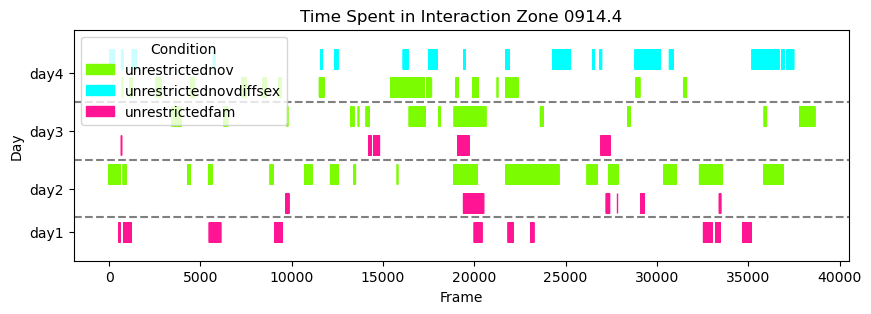

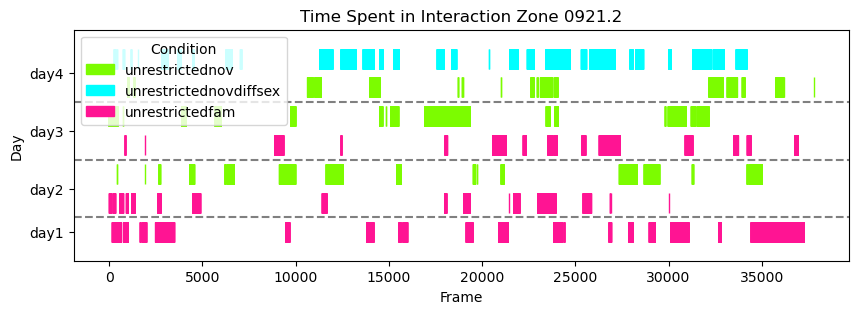

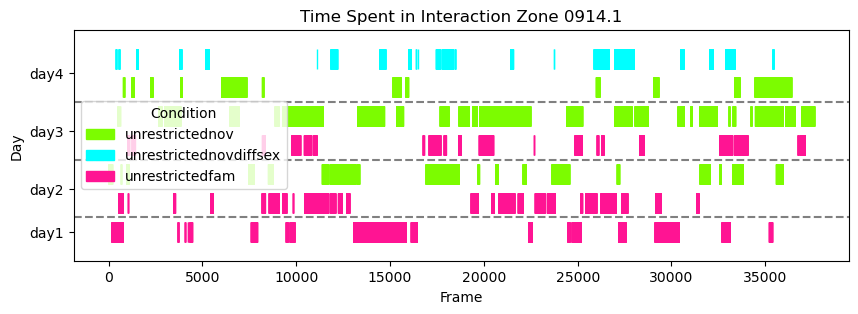

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors for each condition
condition_colors = {
    # "restrictedwheel": "blue",
    "unrestrictednov": "lawngreen",
    "unrestrictednovdiffsex": "cyan",
    "unrestrictedfam": "deeppink"
}

# Extract day number and identifier from the name column
df['day'] = df['name'].str.extract(r'day(\d)').astype(int)
df['id'] = df['name'].str.extract(r'(0914\.1|0914\.4|0921\.2)')[0]

# Filter the DataFrame to only include rows with the specific IDs we're interested in
unique_ids = df['id'].dropna().unique()

# Loop through each unique ID to create a separate raster plot
for identifier in unique_ids:
    # Filter the DataFrame for the current identifier
    df_id = df[df['id'] == identifier].sort_values(by=['day', 'condition']).reset_index(drop=True)
    
    # Initialize lists to store frame indices and conditions
    filtered_frames = []
    conditions = []
    
    # Loop through each row to calculate frame indices within the interaction zone
    for i, row in df_id.iterrows():
        head_x = np.array(row['head_x']).astype(float)
        head_y = np.array(row['head_y']).astype(float)
        
        # Define interaction zone
        int_zone = (head_x >= 300) & (head_x <= 400) & (head_y >= 200) & (head_y <= 250)
        frame_indices = np.where(int_zone)[0]  

        filtered_frames.append(frame_indices)
        conditions.append(row['condition'])  # Store condition for color

    # Create a raster plot for the current identifier
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot each trial's data with the appropriate color based on condition
    for i, (frames, condition) in enumerate(zip(filtered_frames, conditions)):
        ax.plot(frames, np.ones_like(frames) * i, '|', color=condition_colors[condition], markersize=15)

    # Labeling the plot
    ax.set_title(f'Time Spent in Interaction Zone {identifier}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Day')

    # Adjust y-axis labels to display each day only once
    unique_days = df_id['day'].unique()
    day_labels = []
    day_positions = []

    for day in unique_days:
        day_indices = df_id[df_id['day'] == day].index
        center_position = (day_indices[0] + day_indices[-1]) / 2
        day_labels.append(f'day{day}')
        day_positions.append(center_position)

    ax.set_yticks(day_positions)
    ax.set_yticklabels(day_labels)

    # Draw dotted lines between days
    for day in unique_days[1:]:  # Skip the first day to avoid a line at the top
        idx = df_id[df_id['day'] == day].index[0] - 0.5
        ax.axhline(idx, linestyle='--', color='gray')

    ax.set_ylim(-1, len(filtered_frames))

    # Create legend
    legend_patches = [mpatches.Patch(color=color, label=condition) for condition, color in condition_colors.items()]
    ax.legend(handles=legend_patches, title="Condition",loc='upper right')

    # Show the plot for this identifier
    plt.show()


In [40]:
df['filtered_frames'] = filtered_frames
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,tailbase_x,tailbase_y,head_x,head_y,filtered_frames
0,day4_unrestrictednovdiffgen_0921.2.h5,day4_unrestrictednovdiffgen_0921.2,"(36443, 5, 2, 1)","[[[[486.08624268], [347.93881226]], [[401.6648...",unrestrictednovdiffgen,"[486.08624267578125, 486.0962219238281, 486.10...","[347.9388122558594, 347.9343566894531, 347.920...","[401.6648864746094, 401.7660827636719, 401.953...","[252.08419799804688, 252.33084106445312, 253.7...","[426.0223693847656, 426.1258239746094, 429.797...","[277.5411376953125, 277.65594482421875, 276.03...","[460.17218017578125, 460.17218017578125, 460.1...","[268.06573486328125, 268.06573486328125, 268.0...","[291.8656311035156, 291.98162841796875, 291.98...","[365.9250183105469, 365.84356689453125, 365.84...","[413.8436279296875, 413.9459533691406, 415.875...","[264.8126678466797, 264.99339294433594, 264.89...","[267, 273, 274, 275, 276, 277, 278, 279, 280, ..."
1,day4_unrestrictednov_0914.1.h5,day4_unrestrictednov_0914.1,"(36486, 5, 2, 1)","[[[[429.88739014], [31.91365051]], [[111.73435...",unrestrictednov,"[429.88739013671875, 429.88739013671875, 429.8...","[31.913650512695312, 31.913650512695312, 31.91...","[111.73435974121094, 111.73435974121094, 111.7...","[36.3763542175293, 36.3763542175293, 36.376354...","[258.45001220703125, 258.45001220703125, 258.4...","[65.54484558105469, 65.54484558105469, 65.5448...","[249.9493408203125, 249.9493408203125, 249.949...","[67.9067611694336, 67.9067611694336, 67.906761...","[220.03343200683594, 220.03343200683594, 220.0...","[50.02627182006836, 50.02627182006836, 50.0262...","[185.0921859741211, 185.0921859741211, 185.092...","[50.96059989929199, 50.96059989929199, 50.9605...","[763, 764, 792, 793, 798, 799, 803, 804, 805, ..."
2,day4_unrestrictednov_0921.2.h5,day4_unrestrictednov_0921.2,"(37814, 5, 2, 1)","[[[[400.0894165], [323.83877563]], [[429.97332...",unrestrictednov,"[400.08941650390625, 400.08941650390625, 400.0...","[323.8387756347656, 323.8387756347656, 323.838...","[429.97332763671875, 429.97332763671875, 429.9...","[280.38983154296875, 280.38983154296875, 280.3...","[422.358154296875, 422.358154296875, 422.35815...","[290.0234069824219, 290.0234069824219, 290.023...","[387.84619140625, 387.84619140625, 387.8461914...","[363.9315185546875, 363.9315185546875, 363.931...","[508.4274597167969, 508.4274597167969, 508.427...","[145.94381713867188, 145.94381713867188, 145.9...","[426.1657409667969, 426.1657409667969, 426.165...","[285.2066192626953, 285.2066192626953, 285.206...","[995, 996, 997, 998, 999, 1000, 1001, 1002, 10..."
3,day4_unrestrictednov_0914.4.h5,day4_unrestrictednov_0914.4,"(37514, 5, 2, 1)","[[[[361.94342041], [171.58613586]], [[642.1916...",unrestrictednov,"[361.94342041015625, 361.94342041015625, 361.9...","[171.5861358642578, 171.5861358642578, 171.586...","[642.191650390625, 642.191650390625, 642.19165...","[203.82705688476562, 203.82705688476562, 203.8...","[219.7444610595703, 219.7444610595703, 219.744...","[167.72828674316406, 167.72828674316406, 167.7...","[560.2880859375, 560.2880859375, 560.288085937...","[213.92457580566406, 213.92457580566406, 213.9...","[71.92131805419922, 71.92131805419922, 71.9213...","[183.8136749267578, 183.8136749267578, 183.813...","[430.96805572509766, 430.96805572509766, 430.9...","[185.77767181396484, 185.77767181396484, 185.7...","[721, 722, 723, 724, 1162, 1163, 1164, 1165, 1..."
4,day4_unrestrictednovdiffgen_0914.4.h5,day4_unrestrictednovdiffgen_0914.4,"(37600, 5, 2, 1)","[[[[415.77566528], [260.19158936]], [[400.0067...",unrestrictednovdiffgen,"[415.7756652832031, 415.9898681640625, 416.126...","[260.19158935546875, 260.1219177246094, 259.94...","[400.0067138671875, 400.0067138671875, 401.772...","[251.85997009277344, 251.85997009277344, 250.2...","[409.9463195800781, 409.9391174316406, 409.978...","[284.02593994140625, 283.9768981933594, 283.83...","[374.0657958984375, 374.01

In [41]:
percent_interact = []
for i in range(0, len(df)):
    int_frames = len(df["filtered_frames"][i])
    total_frames = df["location shape"].iloc[i][0]
    temp_percent = (int_frames/total_frames)*100
    percent_interact.append(temp_percent)

df['percent_interact'] = percent_interact

df['name'],df['percent_interact']


(0    day4_unrestrictednovdiffgen_0921.2
 1           day4_unrestrictednov_0914.1
 2           day4_unrestrictednov_0921.2
 3           day4_unrestrictednov_0914.4
 4    day4_unrestrictednovdiffgen_0914.4
 5           day4_restrictedwheel_0914.4
 6           day4_restrictedwheel_0921.2
 7           day4_restrictedwheel_0914.1
 8     day4_unrestictednovdiffgen_0914.1
 Name: name, dtype: object,
 0    24.100650
 1    10.998739
 2     7.301529
 3     9.601749
 4    12.946809
 5    20.129870
 6    13.212061
 7    36.459205
 8    11.000917
 Name: percent_interact, dtype: float64)

# Analysis

In [96]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [160]:
df

,file_name,name,location shape,locations,condition,nose_x,nose_y,leftear_x,leftear_y,rightear_x,rightear_y,torso_x,torso_y,tailbase_x,tailbase_y,head_x,head_y,filtered_frames
0,day1_unrestricted_fam_0914.1.h5,day1_unrestricted_fam_0914.1,"(36158, 5, 2, 1)","[[[[328.10894775], [245.99966431]], [[249.8783...",unrestricted_fam,"[328.10894775390625, 328.10894775390625, 328.1...","[245.99966430664062, 245.99966430664062, 245.9...","[249.87838745117188, 248.16192626953125, 247.9...","[328.2353820800781, 331.80889892578125, 334.17...","[366.11419677734375, 366.11419677734375, 366.1...","[299.91387939453125, 299.91387939453125, 299.9...","[292.0751037597656, 292.0677185058594, 293.875...","[322.0771179199219, 322.1067199707031, 323.910...","[198.06533813476562, 199.88351440429688, 198.3...","[343.96868896484375, 347.79302978515625, 344.3...","[307.9962921142578, 307.1380615234375, 307.044...","[314.0746307373047, 315.86138916015625, 317.04...","[170, 171, 172, 173, 174, 175, 176, 189, 190, ..."
1,day1_unrestricted_fam_0921.2.h5,day1_unrestricted_fam_0921.2,"(37739, 5, 2, 1)","[[[[391.9543457], [268.32357788]], [[303.87542...",unrestricted_fam,"[391.954345703125, 391.954345703125, 391.95434...","[268.3235778808594, 268.3235778808594, 268.323...","[303.87542724609375, 303.8841857910156, 304.01...","[346.1830139160156, 346.1942138671875, 347.748...","[388.13848876953125, 388.13848876953125, 388.1...","[286.0009765625, 286.0009765625, 286.000976562...","[356.1433410644531, 357.7359313964844, 357.790...","[333.7795104980469, 332.24163818359375, 332.24...","[318.1454772949219, 403.9490051269531, 403.957...","[369.8558044433594, 312.0897521972656, 312.083...","[346.0069580078125, 346.01133728027344, 346.07...","[316.0919952392578, 316.09759521484375, 316.87...","[163, 177, 178, 179, 180, 181, 182, 183, 184, ..."
2,day1_unrestricted_fam_0914.4.h5,day1_unrestricted_fam_0914.4,"(35830, 5, 2, 1)","[[[[86.00053406], [238.12364197]], [[188.03120...",unrestricted_fam,"[86.00053405761719, 85.94876861572266, 85.9131...","[238.12364196777344, 240.00225830078125, 240.0...","[188.0312042236328, 188.0312042236328, 188.031...","[259.93585205078125, 259.93585205078125, 259.9...","[157.96873474121094, 158.1936492919922, 158.19...","[311.9613037109375, 311.9475402832031, 311.947...","[107.86701202392578, 107.87992095947266, 107.8...","[280.1817626953125, 280.22216796875, 281.78042...","[75.90441131591797, 74.00616455078125, 74.0131...","[242.04994201660156, 243.94480895996094, 243.9...","[172.99996948242188, 173.1124267578125, 173.11...","[285.9485778808594, 285.9416961669922, 285.941...","[522, 523, 524, 525, 526, 810, 811, 812, 813, ..."
3,day1_restrictwheel_0914.1.h5,day1_restrictwheel_0914.1,"(18412, 5, 2, 1)","[[[[313.98989868], [266.08782959]], [[279.9517...",restrictwheel,"[313.9898986816406, 313.9898986816406, 313.989...","[266.08782958984375, 266.08782958984375, 266.0...","[279.95172119140625, 279.95172119140625, 279.9...","[271.9319763183594, 271.9319763183594, 271.931...","[288.16485595703125, 288.16717529296875, 288.1...","[314.0661926269531, 314.0747375488281, 314.079...","[224.00013732910156, 223.9734344482422, 223.97...","[294.2649230957031, 294.262451171875, 294.2531...","[164.11325073242188, 164.11709594726562, 164.1...","[346.0220642089844, 346.02056884765625, 346.02...","[284.05828857421875, 284.0594482421875, 284.05...","[292.99908447265625, 293.00335693359375, 293.0...","[1732, 2465, 2466, 2676, 2677, 2678, 2679, 268..."
4,day1_restrictwheel_0921.2.h5,day1_restrictwheel_0921.2,"(21032, 5, 2, 1)","[[[[299.98522949], [205.885849]], [[296.089752...",restrictwheel,"[299.9852294921875, 299.9866943359375, 299.984...","[205.88584899902344, 205.90716552734375, 205.9...","[296.0897521972656, 294.22149658203125, 294.21...","[247.9974822998047, 248.05923461914062, 248.06...","[333.8031311035156, 333.74945068359375, 333.75...","[225.8721160888672, 225.9387664794922, 225.953...","[334.05322265625, 334.0243835449219, 333.92385...","[286.0609130859375,

Text(0.5, 1.0, 'Ear tracks')

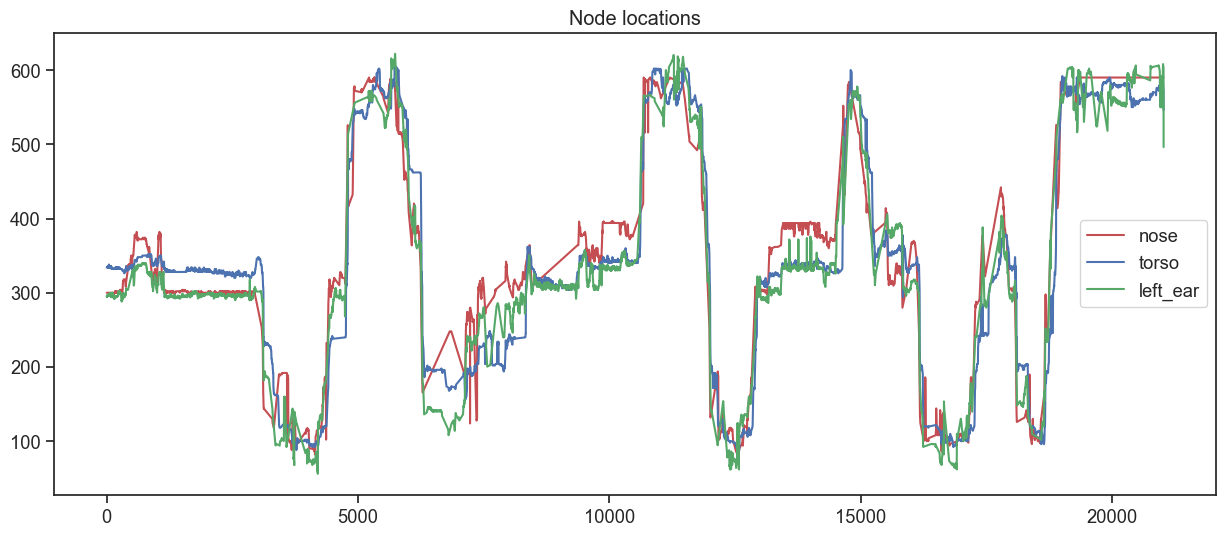

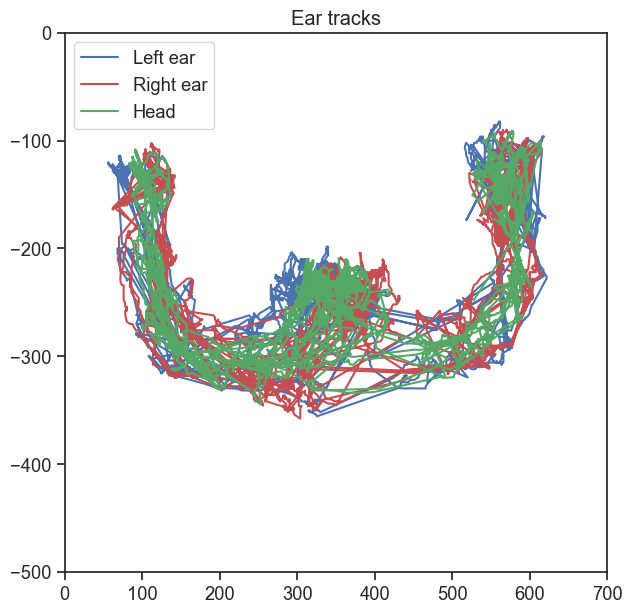

In [167]:
i = 4
plt.figure()
plt.plot(df['nose_x'].iloc[i], 'r',label='nose')
# plt.plot(-1*nose_loc[:,1,0], 'r')
plt.plot(df['torso_x'].iloc[i], 'b',label='torso')
plt.plot(df['leftear_x'].iloc[i], 'g',label='left_ear')
# plt.plot(rightear_loc[:,0,0], 'y',label='right_ear')

plt.legend(loc="center right")
plt.title('Node locations')


plt.figure(figsize=(7,7))
# plt.plot(df['nose_x'][i],-1*df['nose_y'][i], 'b',label='day1_ctrl')
plt.plot(df['leftear_x'][i],-1*df['leftear_y'][i], 'b',label='Left ear')
plt.plot(df['rightear_x'][i],-1*df['rightear_y'][i], 'r',label='Right ear')
plt.plot(df['head_x'][i],-1*df['head_y'][i], 'g',label='Head')


plt.legend()

plt.xlim(0,700)
# plt.xticks([])

plt.ylim(-500,0)
#plt.yticks([])
plt.title('Ear tracks')

# color 250-450 as "interaction phase"


In [ ]:
import matplotlib.animation as animation  
# generate video 



# creating a blank window 
# for the animation  
fig = plt.figure(figsize=(7,7))  
# plt.figure(figsize=(7,7))
axis = plt.axes(xlim =(0, 675), 
                ylim =(-400, 0)) 
line, = axis.plot([], [], lw = 2)  


plt.title('Head position')
   
# what will our line dataset 
# contain? 
def init():  
    line.set_data([], [])  
    return line,  
   
# initializing empty values 
# for x and y co-ordinates 
xdata, ydata = [], []  
   
# animation function  
def animate(i):  
    # t is a parameter which varies 
    # with the frame number 

    t = 0  
       
    # x, y values to be plotted  
    x = df['head_x'][t][i]
    y = -1*df['head_y'][t][i]
       
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  

    # axis.set_xlim =([0, 700])
    # axis.set_ylim =([-500, 0])
      
    return line, 
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = 60000, interval = 1, blit = True)  
   
# saves the animation in our desktop 
anim.save('test.mp4', writer = 'ffmpeg', fps = 240) 
# plt.show()

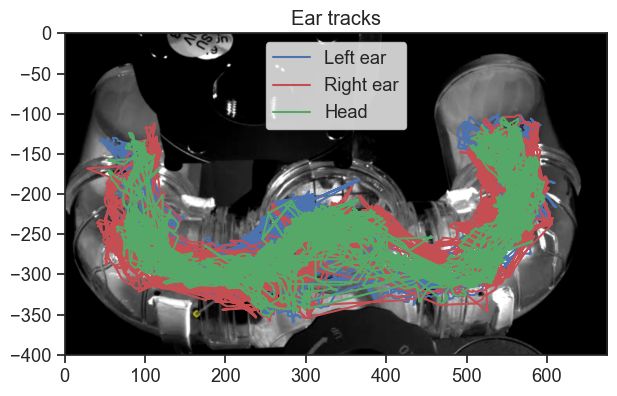

In [159]:
import matplotlib.pyplot as plt

# Load the image
img = plt.imread("day1_restrictwheel_0914.1.png")

# Set up the figure and axes with the specified size
fig, ax = plt.subplots(figsize=(7, 7))

# Display the image in the background
ax.imshow(img, extent=[0, 675, -400, 0])

# Plot the ear and head tracks
i = 0  # Example index; modify as needed for specific trials or data points
ax.plot(df['leftear_x'][i], -1 * df['leftear_y'][i], 'b', label='Left ear')
ax.plot(df['rightear_x'][i], -1 * df['rightear_y'][i], 'r', label='Right ear')
ax.plot(df['head_x'][i], -1 * df['head_y'][i], 'g', label='Head')

# Set limits to match the image size
ax.set_xlim(0, 675)
ax.set_ylim(-400, 0)

# Add legend and title
ax.legend()
ax.set_title('Ear tracks')

plt.show()


In [35]:

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [40]:
nose_loc = df['nose_x'].iloc[i],df['nose_y'].iloc[i]
nose_vel = smooth_diff(nose_loc)
# torso_vel = smooth_diff(torso_loc[:,:,0])


AttributeError: 'tuple' object has no attribute 'shape'

Text(0.5, 1.0, 'Velocity')

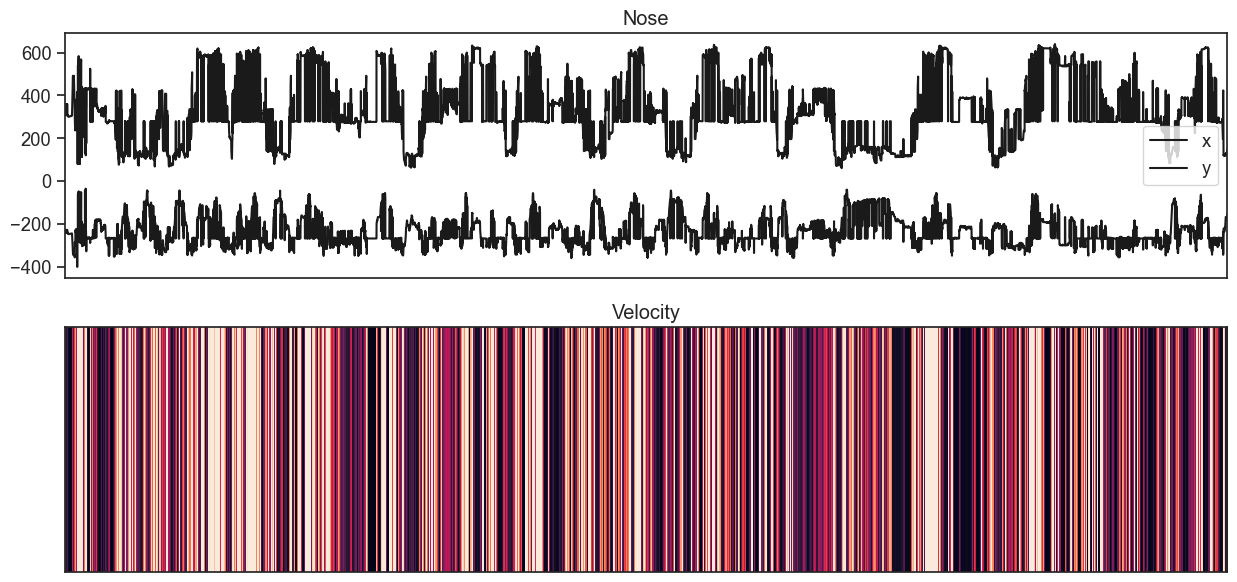

In [65]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(nose_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*nose_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Nose')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(nose_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Nose tracks colored by magnitude of animal speed')

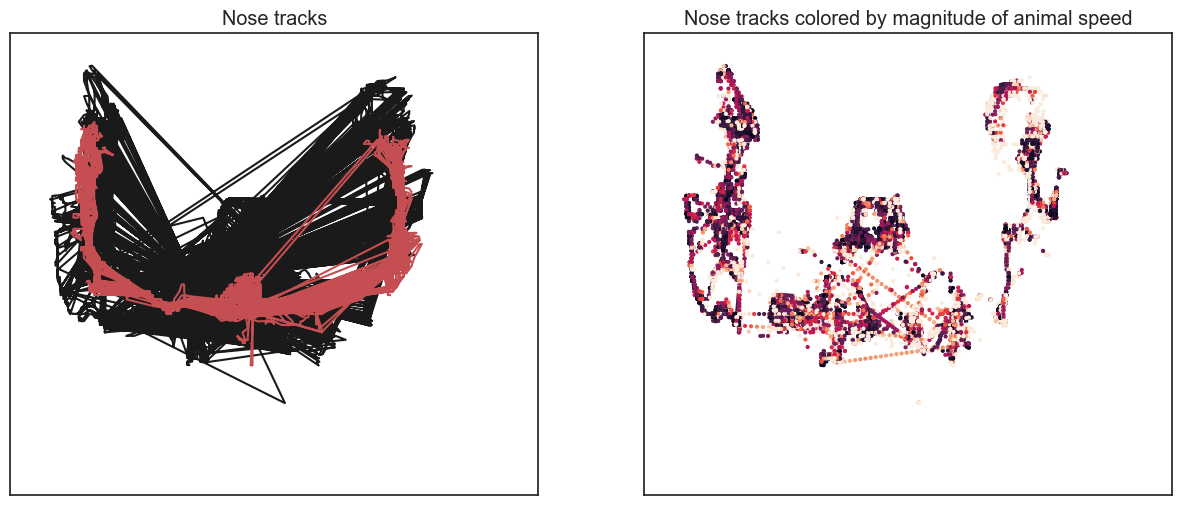

In [66]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(nose_loc[:, 0, 0], -1*nose_loc[:, 1, 0], 'k')
ax1.plot(torso_loc[:, 0, 0], -1*torso_loc[:, 1, 0], 'r')
ax1.set_xlim(0,800)
ax1.set_xticks([])
ax1.set_ylim(-500,0)
ax1.set_yticks([])
ax1.set_title('Nose tracks')

kp = nose_vel  
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(nose_loc[:,0,0], -1*nose_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)

ax2.set_xlim(0,800)
ax2.set_xticks([])
ax2.set_ylim(-500,0)
ax2.set_yticks([])
ax2.set_title('Nose tracks colored by magnitude of animal speed')


# lp = torso_vel
# ax3 = fig.add_subplot(120)
# ax3.scatter(torso_loc[:,0,0], -1*torso_loc[:,1,0], c=lp, s=4, vmin=vmin, vmax=vmax)

# ax3.set_xlim(0,800)
# ax3.set_xticks([])
# ax3.set_ylim(-500,0)
# ax3.set_yticks([])
# ax3.set_title('Torso tracks colored by magnitude of animal speed')

In [37]:
def instance_node_velocities(instance_idx):
    node_locations = locations[:, :, :, instance_idx]
    node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        node_velocities[:, n] = smooth_diff(node_locations[:, n, :])
    
    return node_velocities

In [38]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Animal {instance_idx} node velocities')

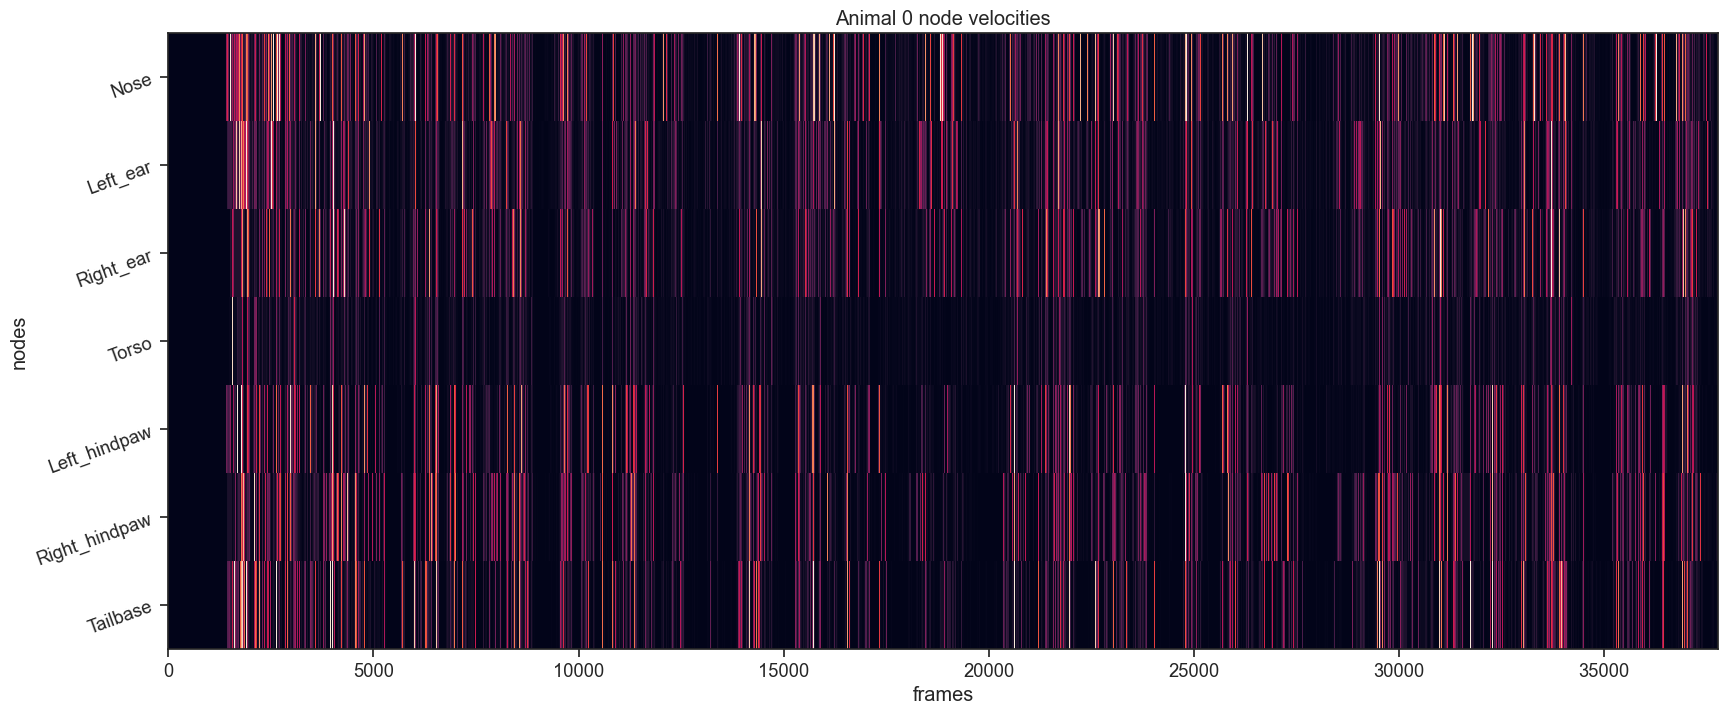

In [39]:
animal_ID = 0
node_velocities = instance_node_velocities(animal_ID)
plot_instance_node_velocities(animal_ID, node_velocities)